In [ ]:
from pyod.models.copod import COPOD
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pyod
import pyod.models.auto_encoder_torch as ae
import pyod.models.cblof as cblof
import pyod.models.knn as knn
from sklearn.preprocessing import StandardScaler
import stumpy
from statsmodels.tsa.ar_model import AutoReg
from dao import DataLoading_dao

# Potentially added at a later point, but need it install SUOD on Conda
# import pyod.models.suod as SUOD

In [ ]:
def plot_results(data, anamoly_score, threshold, anamoly_pos, title, file_to_load):
    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(title)
    ax1.plot(total[0:threshold], color = 'gray')
    ax1.plot(total[threshold:], color = 'blue')
    ax1.set_ylabel('Value')
    ax1.axvline(threshold, label='threshold', color = 'black')
    ax1.axvline(anamoly_pos, label='predicted anamoly', color = 'red')
    ax2.plot(anamoly_score[0:threshold], color = 'gray')
    ax2.plot(anamoly_score[threshold:], color = 'blue')
    ax2.set_ylabel('Anamoly Score')
    ax2.axvline(threshold, label='threshold', color = 'black')
    ax2.axvline(anamoly_pos, label='predicted anamoly', color = 'red')
    plt.show()

In [ ]:
# Define split data

def split_data(file_path, index):
    file_name = os.listdir(file_path)[index]
    test_data_start_pt = int(re.findall(
        r'[0-9]*.txt', file_name)[0].split('.')[0])
    total_data = pd.read_csv(os.path.join(file_path, os.listdir(file_path)[index]))
    train_data = total_data[0:test_data_start_pt]
    test_data = total_data[test_data_start_pt+1:len(total_data)]
    #scaler = StandardScaler()
    #scaler.fit(train_data)
    #train_scaled = scaler.transform(train_data)
    #test_scaled = scaler.transform(test_data)
    return train_data, test_data, total_data, test_data_start_pt

In [ ]:
def calculate_prominence_without_smoothing(anomaly_scores):
    #In this case we define anomaly score as simply the division between the highest anomaly score and the second highest
    highest_anomaly_score = sorted(zip(range(anomaly_scores.shape[0]),anomaly_scores), key = lambda x : x[1], reverse = True)[0][1]
    second_highest_anomaly_score = sorted(zip(range(anomaly_scores.shape[0]),anomaly_scores), key = lambda x : x[1], reverse = True)[1][1]
    return highest_anomaly_score/second_highest_anomaly_score

In [ ]:
#reduces the noise of anomaly detection and increases the stability of anomaly detection
def smoothing(anomaly_data,m):
    start_point = m
    end_point_for_smoothing = anomaly_data.shape[0] - 1
    smoothed_anomaly_scores = np.zeros(shape = (anomaly_data.shape[0]))
    for i in range(start_point,end_point_for_smoothing):
        #smoothed_anomaly_scores[i] = np.mean(anomaly_data[i - m:i+1])
        smoothed_anomaly_scores[i] = np.mean(anomaly_data[i - m:i + 1])
    return smoothed_anomaly_scores

#prominence is defined as the ratio of the first peak in time range 0 to Tmax 
#and the second peak in the time ranges 0 to t1 - m and t1 + m to Tmax (t1 is position of first peak)
def calculate_prominence(anomaly_scores,m):
    anomaly_scores = tuple(zip(range(anomaly_scores.shape[0]),anomaly_scores))
    #finding first highest anomaly score in the range 0 to Tmax
    highest_score = sorted(anomaly_scores,key = lambda x:x[1],reverse=True)[0]
    #time at which this score is found is t1
    highest_score
    #finding second highest score from the ranges 0 to t1  - m
    try:
        second_score_1 = sorted(anomaly_scores[:highest_score[0] - m],key = lambda x:x[1],reverse=True)[0]
    except:
        second_score_1 = sorted(anomaly_scores[:highest_score[0]],key = lambda x:x[1],reverse=True)[0]
    try:
        second_score_2 = sorted(anomaly_scores[highest_score[0] + m:],key = lambda x:x[1],reverse=True)[0]
    except:
        second_score_2 = sorted(anomaly_scores[highest_score[0]:],key = lambda x:x[1],reverse=True)[0]
    second_highest_score = max(second_score_1,second_score_2,key=lambda x:x[1])
    prominence = highest_score[1]/second_highest_score[1]
    #after prominence is calculate, the point of outlier is selected as the time of the first peak location 
    #(time at which higest score occurs)
    return prominence

In [ ]:
def train_models(train,test,threshold):
    
    # Autoencoder
    anamoly_pos_autoenc, test_outlier_scores_autoenc, prominence_score_autoenc = Detect_AE()

    # Cluster-based Local Outlier Factor
    anamoly_pos_CBLOF, test_outlier_scores_CBLOF, prominence_score_CBLOF = Detect_CBLOF()

    # K-Nearest Neighbors
    anamoly_pos_KNN, test_outlier_scores_KNN, prominence_score_KNN = Detect_KNN()

    # Copula-Based Outlier Detection
    anamoly_pos_COPOD, test_outlier_scores_COPOD, prominence_score_COPOD = Detect_COPOD()

    # Matrix Profile Algorithm

    anamoly_pos_MP, test_outlier_scores_MP, prominence_score_MP = Detect_MatrixProfile(train,test,threshold)

    # AutoRegressive Algorithm 

    anamoly_pos_AR, test_outlier_scores_AR, prominence_score_AR = Detect_AutoRegression(train,test,threshold)

    
    return anamoly_pos_autoenc, anamoly_pos_CBLOF, anamoly_pos_KNN, anamoly_pos_COPOD,anamoly_pos_MP,anamoly_pos_AR, \
           prominence_score_autoenc, prominence_score_CBLOF, prominence_score_KNN, prominence_score_COPOD, prominence_score_MP, prominence_score_AR
    

In [ ]:
def Detect_AE():
    # Implement algorithm #1 (Autoencoding)
    # https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod-models-auto-encoder-module

    # Define model (TBD hidden neuron details...)
    clf = ae.AutoEncoder(epochs = 2)

    # Fit model
    clf.fit(train)
    
    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_
    
    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted Anamoloy from Autoencoder algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [ ]:
def Detect_CBLOF():
    # Implement algorithm #2 (CBLOF)
    outliers_fraction = 0.000000001

    # Define model (TBD hidden neuron details...)
    clf = cblof.CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted Anamoloy from CBLOF algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [ ]:
def Detect_KNN():
    # Implement algorithm #3 (K-Nearest Neighbors)
    outliers_fraction = 0.000000001

    # Define model (TBD hidden neuron details...)
    clf = knn.KNN(contamination=outliers_fraction)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted anamoloy from KNN algorithm is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [ ]:
def Detect_COPOD():    
    # Implement algorithm #4 (COPOD)

    ##### COPOD Algorithm
    clf = COPOD()
    clf.fit(train)

    # Fit model
    clf.fit(train)

    # Determine outlier scores for training data
    train_outlier_scores = clf.decision_scores_

    # Determine outlier scores for test data
    test_outlier_scores = clf.decision_function(total)
    test_outlier_scores = pd.Series(test_outlier_scores)
    anamoly_pos = test_outlier_scores[threshold:].idxmax()
    #prominence_score = test_outlier_scores.nlargest(2).iloc[0] / test_outlier_scores.nlargest(2).iloc[1]
    smoothed_anomaly_scores = smoothing(test_outlier_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    print("Predicted anamoloy from COPOD algorithm  is located at location: " + str(anamoly_pos))
    
    return anamoly_pos, test_outlier_scores, prominence_score

In [ ]:
def Detect_MatrixProfile(train,test,threshold):
    #Implement the Matrix Profile Algorithm with a A-B join
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)

    #window size
    m = 100

    mp = stumpy.stump(test.reshape(test.shape[0],),m,train.reshape(train.shape[0],),ignore_trivial=False,normalize=False)

    anomaly_scores = pd.Series(mp[:,0])
    #finding outlier without smoothing
    outlier_position = np.argsort(mp[:,0])[-1]
    print("Predicted anamoloy from MP algorithm  is located at location: " + str(outlier_position + threshold))
    #unsmoothed prominence score
    #prominence_score_matrix_profile = calculate_prominence_without_smoothing(mp[:,0])
    smoothed_anomaly_scores = smoothing(anomaly_scores,100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)


    return outlier_position + threshold, anomaly_scores, prominence_score

In [ ]:
def Detect_AutoRegression(train,test,threshold):
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)
    train_scaled = train
    test_scaled = test
    
    window = 100
    model = AutoReg(train_scaled,lags = window)
    model_fit = model.fit()
    coef = model_fit.params
    #to make the first m predictions in the test data, we need the last 100 data from train dataset
    history = train_scaled[len(train_scaled) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    residual_err = list()

    for t in range(len(test_scaled)):
        length = len(history)
        #finding the past 100 points to predict the next point as prediction requires
        #applying coef from model_fit.params to the lag values
        lag = [history[i] for i in range(length - window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window - d - 1]
        new_history = test_scaled[t]
        predictions.append(yhat)
        history.append(new_history)
        residual_err.append(np.abs(new_history-yhat)[0])
    #smoothed_anomaly_scores = smoothing(np.array(residual_err),m)
    #prominence,outlier_position = calculate_prominence(smoothed_anomaly_scores,m)
    #calculate outlier position without smoothing

    
    outlier_position = np.argsort(np.array(residual_err))[-1]
    #prominence = calculate_prominence_without_smoothing(np.array(residual_err))
    smoothed_anomaly_scores = smoothing(np.array(residual_err),100)
    prominence_score = calculate_prominence(smoothed_anomaly_scores,100)
    outlier_position = outlier_position + threshold
    print("Predicted anamoloy from AR algorithm  is located at location: " + str(outlier_position))
    anomaly_positions_without_smoothing = tuple(zip(range(len(residual_err)),residual_err))
    scores = sorted(anomaly_positions_without_smoothing, key = lambda x:x[1],reverse=True)
    first_outlier_position = scores[0][0] + threshold
    return first_outlier_position, pd.Series(np.array(residual_err)),prominence_score

In [93]:
# Initialize all anamoly lists to be zero

# Filename
file_name_list = []

# Autoencoder
anamoly_pos_autoenc = []
anamoly_prom_autoenc = []

# Cluster-based Local Outlier Factor
anamoly_pos_CBLOF = []
anamoly_prom_CBLOF = []

# K-Nearest Neighbors
anamoly_pos_KNN = []
anamoly_prom_KNN = []

# Copula-Based Outlier Detection
anamoly_pos_COPOD = []
anamoly_prom_COPOD = []

# Matrix Profile
anamoly_pos_MP = []
anamoly_prom_MP = []

# Autoregressive Model
anamoly_pos_AR = []
anamoly_prom_AR = []

# Ensemble prediction
predicted_voting = []
predicted_prom = []

# for k in range(len(os.listdir(file_path))-1):

# subset for testing purposes
for k in range(10):

# full set
# for k in range(250):
    # define path to data directory
    file_path = os.path.join(os.getcwd(), 'KDD-Cup', 'data')
    file_name = os.listdir(file_path)[k+1]
    file_to_load = os.path.join(file_path, file_name)
    train, test, total, threshold = split_data(file_path, k+1)
    
    print("Analysis started for file " + file_name)
    
    autoenc_pred, CBLOF_pred, KNN_pred, COPOD_pred,MP_pred,AR_pred, autoenc_prom, CBLOF_prom, KNN_prom, COPOD_prom,MP_prom,AR_prom = train_models(train,test,threshold)
    
    # Add value for each item to list
    file_name_list.append(file_name) 
    anamoly_pos_autoenc.append(autoenc_pred) 
    anamoly_pos_CBLOF.append(CBLOF_pred) 
    anamoly_pos_KNN.append(KNN_pred) 
    anamoly_pos_COPOD.append(COPOD_pred)
    anamoly_pos_MP.append(MP_pred) 
    anamoly_pos_AR.append(AR_pred)
    anamoly_prom_autoenc.append(autoenc_prom) 
    anamoly_prom_CBLOF.append(CBLOF_prom) 
    anamoly_prom_KNN.append(KNN_prom) 
    anamoly_prom_COPOD.append(COPOD_prom)
    anamoly_prom_MP.append(MP_prom)
    anamoly_prom_AR.append(AR_prom)

    # Initially add zero to the list (voting mechanism handled within data frame below)
    predicted_voting.append(0)
    predicted_prom.append(0)
    
    
# Create Data frame of predicted anamolies
predictions = pd.DataFrame({'File Name': file_name_list, 'AutoEncoder': anamoly_pos_autoenc, 'CBLOF':anamoly_pos_CBLOF, 'KNN': anamoly_pos_KNN,'COPOD':anamoly_pos_COPOD,'MP':anamoly_pos_MP,'AR':anamoly_pos_AR, 'AutoEncoder_prom': anamoly_prom_autoenc, 'CBLOF_prom':anamoly_prom_CBLOF, 'KNN_prom': anamoly_prom_KNN, 'COPOD_prom':anamoly_prom_COPOD,'MP_prom':anamoly_prom_MP,'AR_prom':anamoly_prom_AR, 'Predicted_voting': predicted_voting, 'Predicted_prom':predicted_prom} ) 

# Prominence-based voting
predictions['Predicted_prom'] = np.select(
    [
        predictions['AutoEncoder_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['CBLOF_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['KNN_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['COPOD_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['MP_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
        predictions['AR_prom'] >= predictions[['AutoEncoder_prom', 'CBLOF_prom', 'KNN_prom', 'COPOD_prom','MP_prom','AR_prom']].values.max(1),
    ], 
    [
        predictions['AutoEncoder'],
        predictions['CBLOF'],
        predictions['KNN'],
        predictions['COPOD'],
        predictions['MP'],
        predictions['AR'],
    ], 
    default=-9999
)

# Mode-based voting
predictions['Predicted_voting'] = predictions[['AutoEncoder', 'CBLOF', 'KNN', 'COPOD','MP','AR']].mode(axis=1, dropna=False)[0]

# Display data frame
predictions

Analysis started for file 001_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): D

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61487
Analysis started for file 002_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1):

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 61918
Analysis started for file 003_UCR_Anomaly_35000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1):

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 46705
Analysis started for file 004_UCR_Anomaly_2500.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): 

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5577
Analysis started for file 005_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): L

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5389
Analysis started for file 006_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): L

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5950
Analysis started for file 007_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): L

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6517
Analysis started for file 008_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): L

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 5559
Analysis started for file 009_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): L

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 4849
Analysis started for file 010_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): L

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Predicted anamoloy from AR algorithm  is located at location: 6052


,File Name,AutoEncoder,CBLOF,KNN,COPOD,MP,AR,AutoEncoder_prom,CBLOF_prom,KNN_prom,COPOD_prom,MP_prom,AR_prom,Predicted_voting,Predicted_prom
0,001_UCR_Anomaly_35000.txt,71184,66888,71184,66888,66859,61487,1.148591,1.109888,1.445067,1.053242,1.009811,1.025923,66888.0,71184
1,002_UCR_Anomaly_35000.txt,71390,67095,67095,67095,67064,61918,1.153586,1.009226,1.774339,1.052439,1.506203,1.039229,67095.0,67095
2,003_UCR_Anomaly_35000.txt,71389,71389,67094,67094,67062,46705,1.295731,1.269803,2.039465,1.010824,1.586944,1.339324,67094.0,67094
3,004_UCR_Anomaly_2500.txt,5590,5590,5590,5590,5499,5577,1.122373,1.421397,9.529492,1.157960,2.155883,1.211684,5590.0,5590
4,005_UCR_Anomaly_4000.txt,6253,6253,6254,6253,4685,5389,1.060880,1.035172,1.002447,1.020146,1.310498,1.227827,6253.0,4685
5,006_UCR_Anomaly_4000.txt,6071,5101,6252,5101,4737,5950,1.145316,1.171898,1.327884,1.080703,1.085050,1.018679,5101.0,6252
6,007_UCR_Anomaly_4000.txt,5078,5078,5078,5078,4739,6517,1.067345,1.038581,1.133986,1.039740,1.042138,1.177612,5078.0,6517
7,008_UCR_Anomaly_4000.txt,6700,4791,4790,4791,4728,5559,1.160489,1.179128,1.261872,1.148129,1.530766,3.140538,4791.0,5559
8,009_UCR_Anomaly_4000.txt,6325,6253,6700,6253,4789,4849,1.120833,1.089476,1.144669,1.077588,1.319745,1.519065,6253.0,4849
9,010_UCR_Anomaly_4000.txt,5101,5101,5101,5101,5983,6052,1.056507,1.117419,1.467504,1.180430,1.177213,1.406698,5101.0,5101


In [ ]:
# Creation of final prediction file
submission_file = pd.DataFrame()
submission_file['No.'] = predictions['File Name'].str[:3].astype('int32')
submission_file['Location of Anomaly'] = predictions['Predicted_prom']
submission_file.style.hide_index()

No.,Location of Anomaly
1,66888
2,67064
3,67062
4,5499
5,4685
6,4737
7,6517
8,5559
9,4849
10,6052


In [ ]:
#### Below for development purposes ####
print(file_name)

# Autoencoder
anamoly_pos_autoenc, test_outlier_scores_autoenc, prom_autoenc = Detect_AE()

# Cluster-based Local Outlier Factor
anamoly_pos_CBLOF, test_outlier_scores_CBLOF, prom_CBLOF = Detect_CBLOF()

# K-Nearest Neighbors
anamoly_pos_KNN, test_outlier_scores_KNN, prom_KNN = Detect_KNN()

# Copula-Based Outlier Detection
anamoly_pos_COPOD, test_outlier_scores_COPOD, prom_COPOD = Detect_COPOD()

010_UCR_Anomaly_4000.txt
inner_autoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (batch_norm0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (dropout0): Dropout(p=0.2, inplace=False)
    (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False

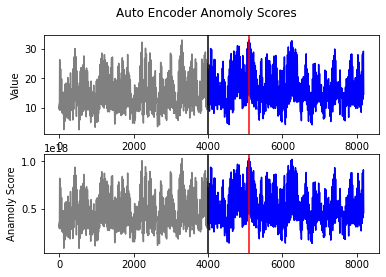

In [ ]:
# Plot results
plot_results(total, test_outlier_scores_autoenc, threshold, anamoly_pos_autoenc, "Auto Encoder Anomoly Scores", file_to_load)

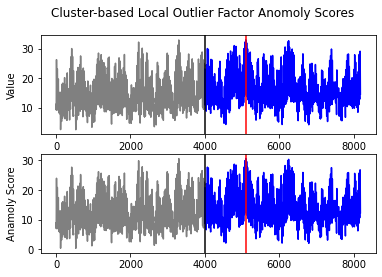

In [ ]:
# Plot results
plot_results(total, test_outlier_scores_CBLOF, threshold, anamoly_pos_CBLOF, "Cluster-based Local Outlier Factor Anomoly Scores", file_to_load)

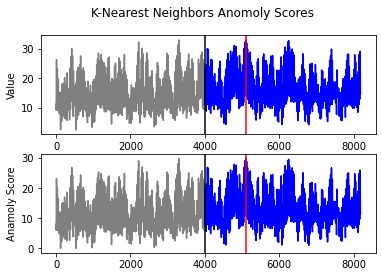

In [ ]:
# Plot results
plot_results(total, test_outlier_scores_KNN, threshold, anamoly_pos_KNN, "K-Nearest Neighbors Anomoly Scores", file_to_load)

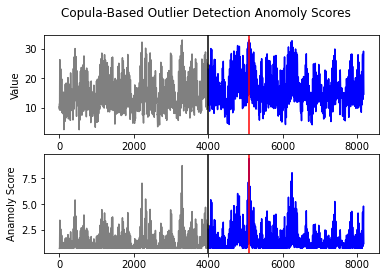

In [ ]:
# Plot
plot_results(total, test_outlier_scores_COPOD, threshold, anamoly_pos_COPOD, "Copula-Based Outlier Detection Anomoly Scores", file_to_load)